<a href="https://colab.research.google.com/github/alivemarin/my-code/blob/main/kg%26_nx_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install torch-geometric
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"
from torch_geometric.data import Data
from torch.nn import Linear
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, MessagePassing
from torch_geometric.utils import to_networkx, add_self_loops, degree
import torch_geometric.transforms as T
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
import networkx as nx
from google.colab import drive
drive.mount('/content/gdrive')

FILE_PATH = 'gdrive/MyDrive/Colab Notebooks/graph/'


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
# 필수 라이브러리 설치
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install spacy networkx matplotlib pandas scikit-learn numpy

# spaCy 모델 다운로드
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 115.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [7]:
# read files
df_node = pd.read_csv('kgn3.csv')
node_feats = df_node.columns[2:]
node_ids = df_node['title'].unique()
le_node = pp.LabelEncoder().fit(node_ids)
df_node['node_idx'] = le_node.transform(node_ids)
labels = df_node['label'].unique()
num_classes = len(labels)

df_edge = pd.read_csv('kge3.csv')
edge_feats = df_edge.columns[2:]
df_edge['src_idx'] = le_node.transform(df_edge['src'])
df_edge['dst_idx'] = le_node.transform(df_edge['dst'])

print(50*'+')
print('Number of nodes', len(node_ids))
print('Number of node feauturs', len(node_feats))
print('Number of node classes', num_classes)
print('Number of edges', len(df_edge))
print('Number of edge feauturs', len(edge_feats))

++++++++++++++++++++++++++++++++++++++++++++++++++
Number of nodes 21
Number of node feauturs 3
Number of node classes 3
Number of edges 27
Number of edge feauturs 2


In [8]:
# Convert into graph data structure
x = []
for i, row in df_node.iterrows():
    feats = row[2:2+len(node_feats)]
    x.append(feats)
x = torch.tensor(x, dtype=torch.float)

le_label = pp.LabelEncoder().fit(labels)
y = le_label.transform(df_node['label']).tolist()
y = torch.tensor(y)

srcs = list(df_edge['src_idx'])
dsts = list(df_edge['dst_idx'])
zip1 = list(zip(srcs, dsts))
zip2 = list(zip(dsts, srcs))
zip1_2 = [list(item) for item in zip1]
zip2_2 = [list(item) for item in zip2]
zipped = zip1+zip2
edge_index = torch.tensor(zipped)

e_f=[]
for i, row in df_edge.iterrows():
    feats=row[2:2+len(edge_feats)]
    e_f.append(feats)
e_f=e_f+e_f
edge_attr=torch.tensor(e_f,dtype=torch.float)

graph=Data(x=x, edge_index=edge_index.t().contiguous(), y=y, edge_attr=edge_attr)
graph.num_classes=num_classes
graph.validate(raise_on_error=True)

/tmp/ipython-input-2879957048.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = torch.tensor(x, dtype=torch.float)
/tmp/ipython-input-2879957048.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  edge_attr=torch.tensor(e_f,dtype=torch.float)


True

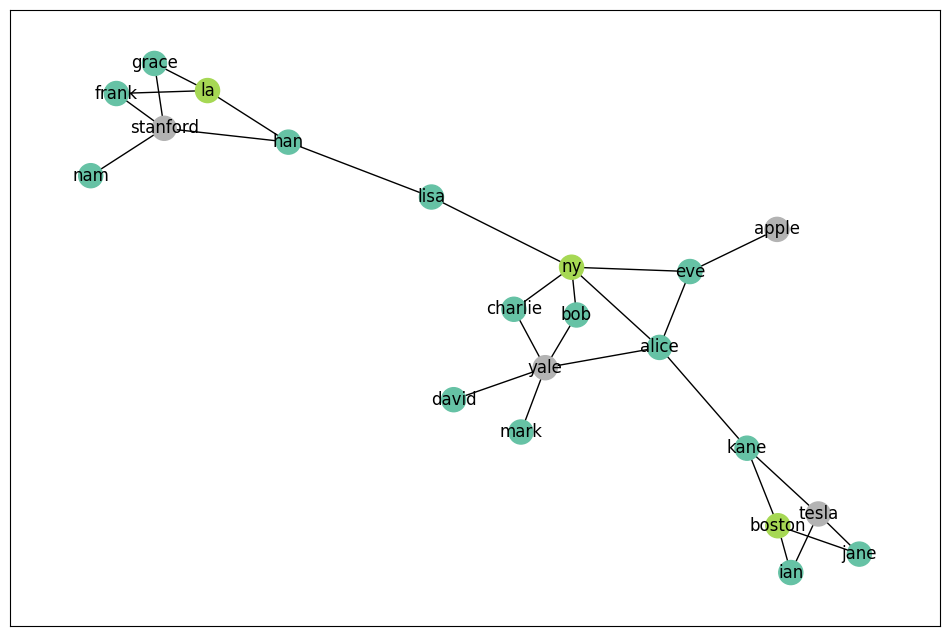

In [9]:
# Visualize grpah
G = to_networkx(graph, to_undirected=True)
plt.figure(figsize=(12,8))
plt.xticks([])
plt.yticks([])
node_labels = {i: df_node.loc[df_node['node_idx'] == i, 'title'].iloc[0] for i in G.nodes}
node_colors = {i: df_node.loc[df_node['node_idx'] == i, 'label'].iloc[0] for i in G.nodes}
node_colors = list(node_colors.values())
nx.draw_networkx(G, pos=nx.spring_layout(G, seed=5647), with_labels=True, node_color=node_colors, cmap="Set2", labels=node_labels)
plt.show()


# Read From Deposit

In [11]:
# Cora dataset
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')
graph = dataset[0]
graph.num_classes = dataset.num_classes

# Define the split rates
RATE_VAL = 0.1
RATE_TEST = 0.2

split = T.RandomNodeSplit(num_val=RATE_VAL, num_test=RATE_TEST)
graph = split(graph)
graph

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], num_classes=7)

# Read From Text


In [14]:
!pip install spacy networkx matplotlib
!python -m spacy download en_core_web_sm
import spacy

nlp = spacy.load("en_core_web_sm")

# 텍스트 파일 불러오기
with open("s.txt", "r", encoding="utf-8") as file:
    text = file.read()

doc = nlp(text)
G = nx.DiGraph()

# 관계 추출 함수 (단순화 버전)
def extract_relation(sent):
    subject = ""
    object_ = ""
    relation = ""
    for token in sent:
        if "subj" in token.dep_:
            subject = token.text
        if "obj" in token.dep_:
            object_ = token.text
        if token.dep_ == "ROOT":
            relation = token.lemma_
    return (subject, relation, object_)

# 문장에서 관계 추출 및 그래프 구성
for sent in doc.sents:
    print(sent)
    sub, rel, obj = extract_relation(sent)
    if sub and rel and obj:
        G.add_node(sub)
        G.add_node(obj)
        G.add_edge(sub, obj, label=rel)


  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Alice loves Bob.
Bob likes apples.


In [13]:
# Create a dummy s.txt file
with open("s.txt", "w", encoding="utf-8") as f:
    f.write("Alice loves Bob. Bob likes apples.")

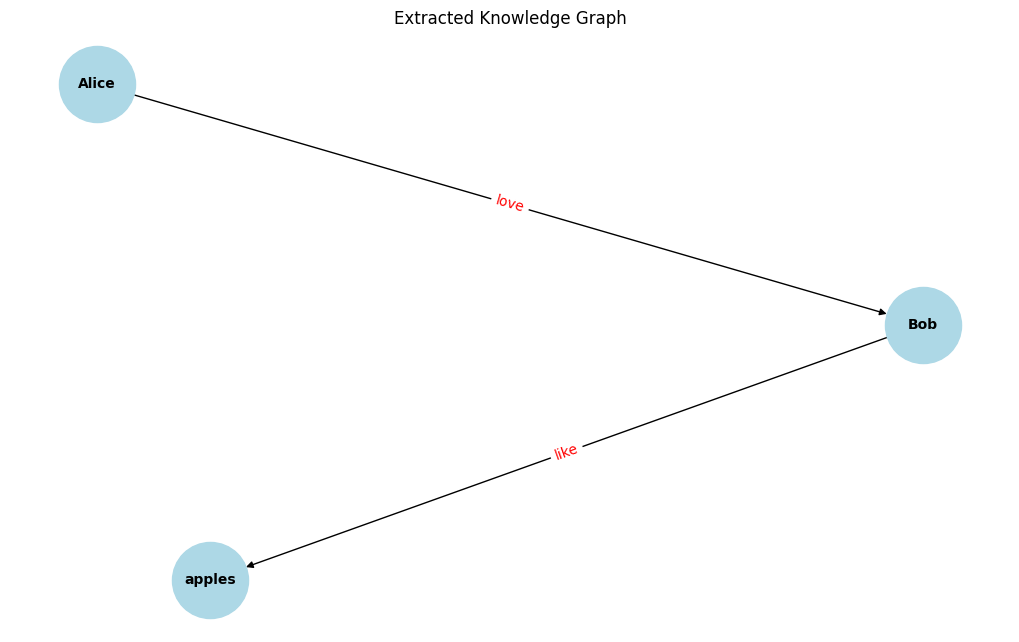

In [15]:
# 그래프 시각화
pos = nx.spring_layout(G)
edge_labels = nx.get_edge_attributes(G, 'label')

plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=3000, font_size=10, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
plt.title("Extracted Knowledge Graph")
plt.show()
